In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy import stats

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
# data source:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged.csv'
file_path3 = '/content/drive/My Drive/X999/bbl_cleaned.csv'
# file_path2 = '/content/drive/My Drive/X999/evictions_pre_post_covid.csv'

In [88]:
# evictions= pd.read_csv(file_path2)
bbl_cleaned= pd.read_csv(file_path3)

In [92]:
# list(bbl_cleaned.columns),
bbl_cleaned.shape
# so 753110 res buildings
# will use this number to calculate the average number of evictions per building, but not only the builingds that
# have the evictions, but all the res buildings

(753110, 110)

In [63]:
# evictions.eviction_count.sum()

757057

In [6]:
bbl_evictions_merged_raw = pd.read_csv(file_path1)

In [7]:
bbl_evictions_merged = bbl_evictions_merged_raw.copy()

In [8]:
display(bbl_evictions_merged.head()), bbl_evictions_merged.shape

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile
0,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,...,walk-up,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",100+ units,True,mega,Q4 (largest 25%)
1,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,...,two-family,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",2-unit,False,small,Q3 (50-75%)
2,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,...,elevator,False,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%)
3,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,...,elevator,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",21-100 units,True,very large,Q4 (largest 25%)
4,33992/16,458984,580 EAST 168TH STREE T,*,2017-01-03,BRONX,10456,Not an Ejectment,Possession,40.830494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(None, (74082, 39))

In [37]:
type(bbl_evictions_merged.executed_date[0]), bbl_evictions_merged.executed_date[0]
bbl_evictions_merged['executed_date'] = pd.to_datetime(bbl_evictions_merged['executed_date'], format='%Y-%m-%d')
bbl_evictions_merged['executed_date'].dt.year.unique() # 5 years

array([2017, 2018, 2019, 2023, 2024], dtype=int32)

In [10]:
building_characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile', 'yearbuilt', 'numfloors', 'unitsres'
]

In [11]:
nan_counts = bbl_evictions_merged[building_characteristics].isna().sum()
nan_percentages = (nan_counts / len(bbl_evictions_merged) * 100).round(3)
# percentage:.3f%

In [12]:
nan_counts, nan_percentages

(yearbuilt                     3770
 bldgclass                     3770
 numfloors                     3770
 unitsres                      3770
 ownername                     3770
 bldgarea                      3770
 building_type                 3770
 building_category             3770
 is_condo                      3770
 floor_category                3770
 rent_era                      3770
 architectural_style           3770
 economic_period               3770
 residential_units_category    3770
 is_llc                        3770
 building_size_category        3770
 size_quartile                 3770
 yearbuilt                     3770
 numfloors                     3770
 unitsres                      3770
 dtype: int64,
 yearbuilt                     5.089
 bldgclass                     5.089
 numfloors                     5.089
 unitsres                      5.089
 ownername                     5.089
 bldgarea                      5.089
 building_type                 5.089
 build

In [13]:
bbl_evictions_merged.shape

(74082, 39)

In [14]:
df = bbl_evictions_merged.copy()

In [15]:
df = bbl_evictions_merged.dropna(subset=['average_year_eviction_count'])

In [16]:
df.shape

(74082, 39)

In [17]:
df_clean = df.dropna(subset=building_characteristics)

In [18]:
df_clean.shape, 74082 - 70312
# good

((70312, 39), 3770)

In [20]:
df_clean['eviction_rate_per_unit'] = df_clean['average_year_eviction_count'] / df_clean['unitsres']
df_clean['eviction_rate_per_unit'] = df_clean['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
# second line handles potential division by zero errors

In [39]:
display(df_clean.head())

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,eviction_rate_per_unit
0,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,...,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",100+ units,True,mega,Q4 (largest 25%),0.016456
1,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,...,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",2-unit,False,small,Q3 (50-75%),0.500000
2,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,...,False,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),0.006667
3,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,...,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",21-100 units,True,very large,Q4 (largest 25%),0.050314
6,50104/16,318266,598 E 183 ST AKA 2239 ADAMS PL,26,2017-01-03,BRONX,10457,Not an Ejectment,Possession,40.853070,...,False,mid-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),0.060345


In [40]:
building_evictions = df.groupby('bbl_clean').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'unitsres': 'first',
    'building_category': 'first',
    'building_type': 'first',
    'is_llc': 'first',
    'yearbuilt': 'first',
    'bldgclass': 'first',
    'numfloors': 'first',
    'bldgarea': 'first',
    'is_condo': 'first',
    'floor_category': 'first',
    'rent_era': 'first',
    'architectural_style': 'first',
    'economic_period': 'first',
    'residential_units_category': 'first',
    'building_size_category': 'first',
    'size_quartile': 'first'
}).reset_index()
building_evictions['eviction_rate_per_unit'] = building_evictions['average_year_eviction_count'] / building_evictions['unitsres']

In [41]:
characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile'
]
characteristics = list(dict.fromkeys(characteristics))
building_evictions['eviction_rate_per_unit'] = building_evictions['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
building_evictions_clean = building_evictions.dropna(subset=['eviction_rate_per_unit'])
current_year = pd.Timestamp.now().year
building_evictions_clean['building_age'] = current_year - building_evictions_clean['yearbuilt']
characteristics.append('building_age')

In [42]:
print(f"total buildings analyzed: {len(building_evictions_clean)}")
print(f"average eviction rate per unit: {building_evictions_clean['eviction_rate_per_unit'].mean():.4f}")

total buildings analyzed: 31545
average eviction rate per unit: 0.3094


In [43]:
numerical_chars = building_evictions_clean[characteristics].select_dtypes(include=[np.number]).columns.tolist()
numerical_chars

['yearbuilt', 'numfloors', 'unitsres', 'bldgarea', 'building_age']

In [44]:
corr_data = pd.DataFrame()
for char in numerical_chars:
    correlation = building_evictions_clean[[char, 'eviction_rate_per_unit']].corr().iloc[0, 1]
    r, p_value = stats.pearsonr(
        building_evictions_clean[char].dropna(),
        building_evictions_clean.loc[building_evictions_clean[char].notna(), 'eviction_rate_per_unit']
    )
    corr_data = pd.concat([corr_data, pd.DataFrame({
        'characteristic': [char],
        'correlation': [correlation],
        'p_value': [p_value],
        'significant': [p_value < 0.05]
    })])

In [45]:
corr_data = corr_data.sort_values(by='correlation', key=abs, ascending=False)

print("correlation with eviction rate (only numerical characteristics):")
print(corr_data)

correlation with eviction rate (only numerical characteristics):
  characteristic  correlation        p_value  significant
0      numfloors    -0.394253   0.000000e+00         True
0       unitsres    -0.176111  4.032848e-218         True
0       bldgarea    -0.173245  4.858287e-211         True
0   building_age    -0.034417   9.700829e-10         True
0      yearbuilt     0.034417   9.700829e-10         True


Text(0.5, 1.0, 'Correlation with eviction rate (only numerical characteristics)')

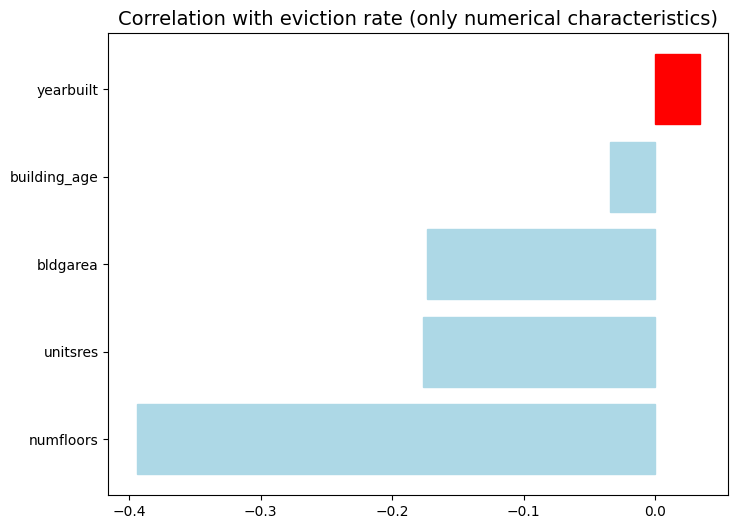

In [46]:
plt.figure(figsize=(8, 6))
bars = plt.barh(corr_data['characteristic'], corr_data['correlation'])
for i, bar in enumerate(bars):
    if corr_data.iloc[i]['significant']:
        if corr_data.iloc[i]['correlation'] > 0:
            bar.set_color('red')
        else:
            bar.set_color('lightblue')
    else:
        bar.set_color('gray')
plt.title('Correlation with eviction rate (only numerical characteristics)', fontsize=14)

- numfloors (-0.394253, p < 0.001) \
This is so far the strongest correlation, showing a moderately strong negative relationship between the number of floors in a building and eviction rates. This means that as the number of floors increases, the eviction rate tends to decrease. In other words, taller buildings generally have lower eviction rates per unit. This correlation is highly statistically significant (with p-value almost zero).
- unitsres (-0.176111, p < 0.001) \
There's a weak to moderate negative correlation between the number of residential units and eviction rates. Buildings with more units tend to have somewhat lower eviction rates per unit. This is also highly statistically significant.
- bldgarea (-0.173245, p < 0.001) \
The building area shows a similar weak to moderate negative correlation with eviction rates. This means, larger buildings (by square footage) tend to have lower eviction rates per unit. This correlation is very similar in strength to the number of units, suggesting these two characteristics may be capturing similar aspects of building size.
- building_age (-0.034417, p < 0.001) and yearbuilt (0.034417, p < 0.001)   \
These show very weak correlations with eviction rates. Building age has a slight negative correlation, meaning older buildings have marginally higher eviction rates. Yearbuilt shows the exact same correlation magnitude but positive, in this case, it makes sense as it's the inverse of building age. While statistically significant due to the large sample size, the practical significance is quite small. In other words, building age appears to have minimal correlation with eviction rates compared to other factors.

**Overall qualitative interpretation:**

- Building size matters: The data strongly suggests that larger buildings (taller, more units, greater area) tend to have lower eviction rates per unit. Some of the factors could be:

- Professional management in larger buildings
- More systematic tenant screening processes
- Economies of scale in maintenance and operations
- Potentially different ownership structures
- etc.


## Categorical analysis:

## 1. Building category (building type)

In [47]:
building_evictions.building_category.unique()
# type of the building, two-family, elevator, etc.....

array([None, 'elevator', 'condo-co-op', 'walk-up',
       'primarily_res_with_mixed_use', 'two-family', 'single-family'],
      dtype=object)

### total count per type of buildings over the years

In [75]:
# display(evictions.head())

In [85]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'building_category', 'building_type', 'is_llc', 'yearbuilt',
       'bldgclass', 'numfloors', 'bldgarea', 'is_condo', 'floor_category',
       'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age'],
      dtype='object')

In [124]:
# because each row is an eviction, use count
category_data = building_evictions.groupby('building_category').agg(
    total_evictions=('eviction_count', 'count')
).reset_index()
total_evictions = category_data['total_evictions'].sum()
category_data['proportion'] = category_data['total_evictions'] / total_evictions
 # from bbl cleaned df
total_building_count = 753110
category_data['building_count'] = category_data['proportion'] * total_building_count

category_data['avg_evictions_per_building'] = category_data['total_evictions'] / category_data['building_count']

num_years = 5  # outside of covid
category_data['yearly_total_evictions'] = category_data['total_evictions'] / num_years
category_data['yearly_avg_per_building'] = category_data['avg_evictions_per_building'] / num_years

In [130]:
# list(bbl_cleaned.columns)

In [202]:
building_counts = bbl_cleaned['bbl'].groupby(bbl_cleaned['building_category']).nunique()
building_counts_df = bbl_cleaned.groupby('building_category')['bbl'].nunique().reset_index()
building_counts_df.columns = ['building_category', 'building_count']
total_buildings = building_counts_df.building_count.sum()
building_counts_df['percentage'] = (building_counts_df['building_count'] / total_buildings) * 100
building_counts_df = building_counts_df.sort_values('building_count', ascending=False)
building_counts_df

,building_category,building_count,percentage
3,single-family,314302,41.733877
4,two-family,250717,33.290887
5,walk-up,131993,17.526391
2,primarily_res_with_mixed_use,33400,4.434943
0,condo-co-op,11814,1.568695
1,elevator,10884,1.445207


In [102]:
category_data

,building_category,total_evictions,proportion,building_count,avg_evictions_per_building,yearly_total_evictions,yearly_avg_per_building
0,condo-co-op,1606,0.050911,38341.881756,0.041886,321.2,0.008377
1,elevator,5918,0.187605,141287.208115,0.041886,1183.6,0.008377
2,primarily_res_with_mixed_use,1661,0.052655,39654.959899,0.041886,332.2,0.008377
3,single-family,2006,0.063592,47891.540973,0.041886,401.2,0.008377
4,two-family,6116,0.193882,146014.289428,0.041886,1223.2,0.008377
5,walk-up,14238,0.451355,339920.119829,0.041886,2847.6,0.008377


In [96]:
# category_data = category_data.sort_values('total_evictions', ascending=False)
# category_data

It makes sense that walk-ups were the most prone to evictions (with the highest eviction sums over the years), given their large portion of buildings in nyc (around 17.83% among all types of buildings, behind single and two family housing). The fact that walk ups tend to be low-rise also matches the results above.

In [114]:
# list(bbl_cleaned.columns)

In [113]:
category_data.building_count.sum(), bbl_cleaned.bbl.count()

(753110.0, 753110)

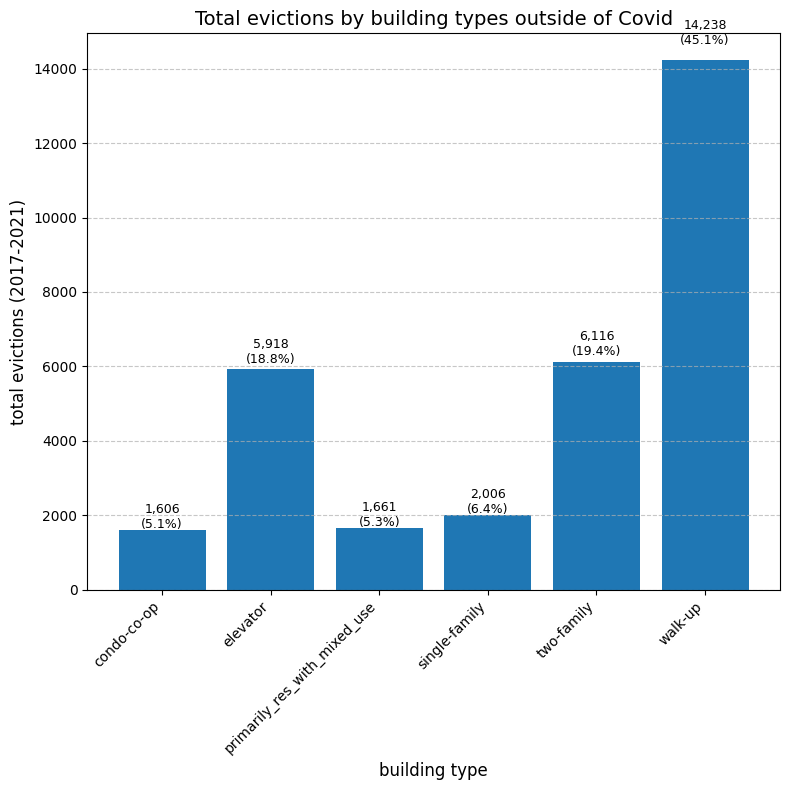

In [184]:
total_all_evictions = category_data['total_evictions'].sum()
category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(8, 8))
bars = plt.bar(category_data['building_category'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['percentage'])):
    plt.text(i, value + (value * 0.03),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('building type', fontsize=12)
plt.ylabel('total evictions (2017-2021)', fontsize=12)
plt.title('Total evictions by building types outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [195]:
category_data_sorted = category_data.sort_values('total_evictions', ascending=False)

In [196]:
category_data_sorted[['building_category', 'total_evictions', 'percentage']]

,building_category,total_evictions,percentage
5,walk-up,14238,45.135521
4,two-family,6116,19.388176
1,elevator,5918,18.760501
3,single-family,2006,6.359169
2,primarily_res_with_mixed_use,1661,5.265494
0,condo-co-op,1606,5.091140


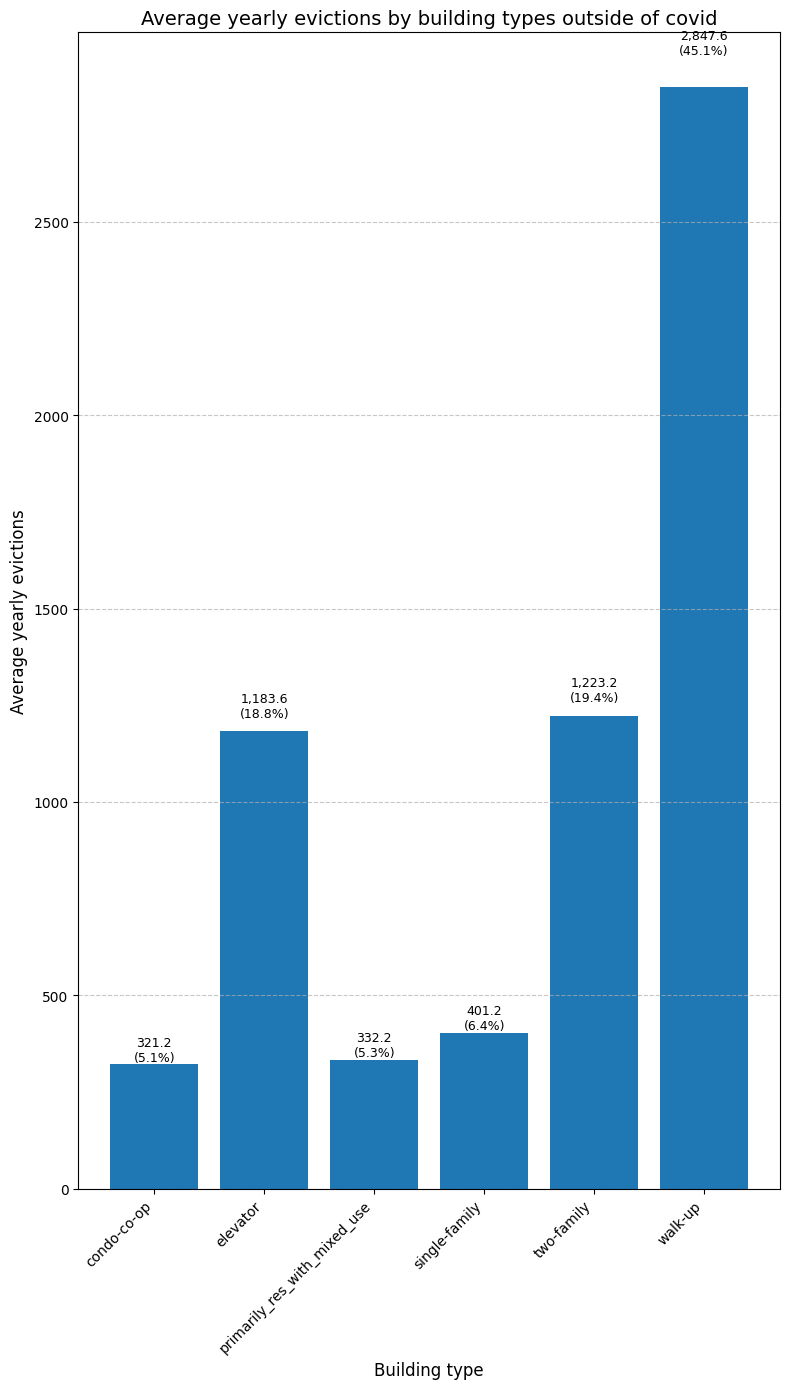

In [183]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions'] / total_yearly_evictions) * 100

plt.figure(figsize=(8, 14))
bars = plt.bar(category_data['building_category'], category_data['yearly_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.03),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building type', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by building types outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [193]:
category_data_sorted = category_data.sort_values('yearly_evictions', ascending=False)

In [194]:
category_data_sorted[['building_category', 'yearly_evictions', 'percentage']]

,building_category,yearly_evictions,percentage
5,walk-up,2847.6,45.135521
4,two-family,1223.2,19.388176
1,elevator,1183.6,18.760501
3,single-family,401.2,6.359169
2,primarily_res_with_mixed_use,332.2,5.265494
0,condo-co-op,321.2,5.091140


### average count per type of building per year outside of covid:


Elevator buildings take the lead, in terms of "per building eviction rate in each type of buildings"

In [172]:
building_counts = pd.DataFrame({
    'building_category': ['condo-co-op', 'elevator', 'primarily_res_with_mixed_use', 'single-family', 'two-family', 'walk-up'],
    'building_count': [11814, 10884, 33400, 314302, 250717, 131993]
})

In [173]:
eviction_counts = pd.DataFrame({
    'building_category': ['condo-co-op', 'elevator', 'primarily_res_with_mixed_use', 'single-family', 'two-family', 'walk-up'],
    'total_evictions': [1606, 5918, 1661, 2006, 6116, 14238]
})

In [174]:
combined_data = pd.merge(building_counts, eviction_counts, on='building_category')
combined_data['yearly_evictions'] = combined_data['total_evictions'] / 5
combined_data['yearly_evictions_per_building'] = combined_data['yearly_evictions'] / combined_data['building_count']

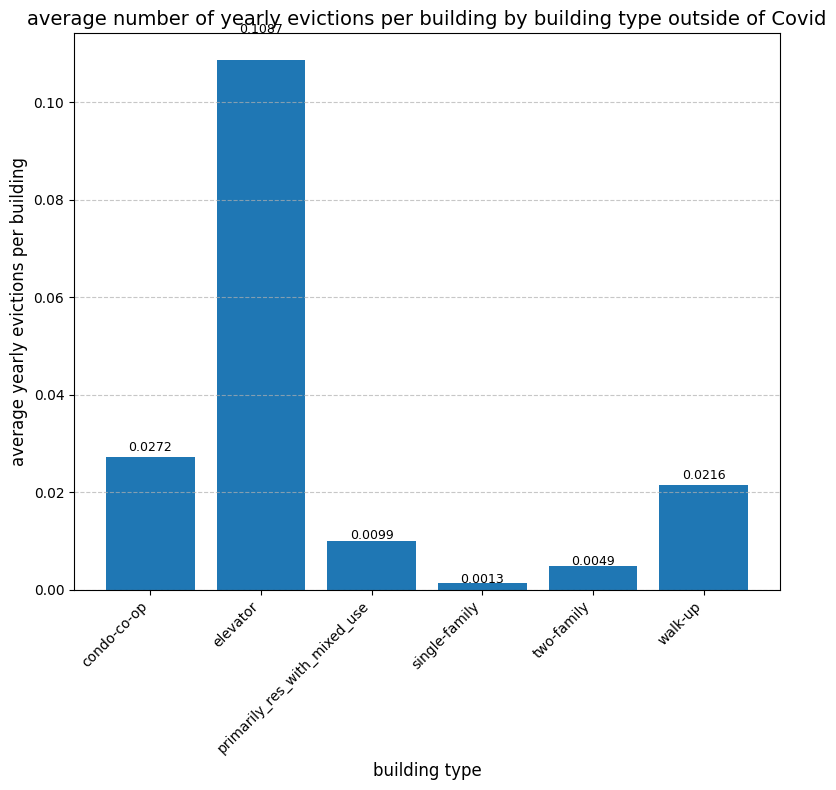

In [205]:
plt.figure(figsize=(8, 8))
bars = plt.bar(combined_data['building_category'], combined_data['yearly_evictions_per_building'])
for i, value in enumerate(combined_data['yearly_evictions_per_building']):
    plt.text(i, value + (value * 0.05),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('building type', fontsize=12)
plt.ylabel('average yearly evictions per building', fontsize=12)
plt.title('average number of yearly evictions per building by building type outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [190]:
combined_data[['building_category', 'building_count', 'total_evictions', 'yearly_evictions', 'yearly_evictions_per_building']]

,building_category,building_count,total_evictions,yearly_evictions,yearly_evictions_per_building
0,condo-co-op,11814,1606,321.2,0.027188
1,elevator,10884,5918,1183.6,0.108747
2,primarily_res_with_mixed_use,33400,1661,332.2,0.009946
3,single-family,314302,2006,401.2,0.001276
4,two-family,250717,6116,1223.2,0.004879
5,walk-up,131993,14238,2847.6,0.021574


In [200]:
print("ranked list of yearly evictions per building:")
sorted_data = combined_data.sort_values('yearly_evictions_per_building', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['building_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_building']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. elevator: 0.1087
2. condo-co-op: 0.0272
3. walk-up: 0.0216
4. primarily_res_with_mixed_use: 0.0099
5. two-family: 0.0049
6. single-family: 0.0013


Eviction findings by building types in NYC (2017-2019, 2023-2024):

- Walk-up buildings have the highest total number of evictions (14,238), accounting for 45.1% of all evictions despite representing only a portion of the city's housing stock (17.526% of all building types).

- elevator buildings have the highest eviction rate per building (0.1087 evictions per building per year), which is approximately 5 times higher than walk-ups at 0.0216 per building per year, the next highest category. But it may not mean elevator buildings are mostly likely to have evictions, because each elevator building usually has way more units than a walk-up/two-family buildings.

- single-family homes have the lowest eviction rate per building (0.0013 evictions per building per year), though they are the most common building type in the dataset (314,302 buildings or 45.14%).

- two-family buildings account for nearly 20% of all evictions, making them the second-highest category by total evictions.

**Further interpretations**
These findings may not contradict with the reverse relationship between the height of the buildings and the eviction rates. The high eviction rate in elevator buildings is likely due to:

- higher density (way more units per building)
- professional management with standardized eviction procedures
- rental (versus owned) units are more likely to face evictions
- The walk-up buildings' dominance in total evictions reflects their prevalence in NYC's housing landscape and their role as affordable housing options, and therefore potentially for more economically vulnerable populations.
- The low eviction rates in single-family and two-family homes likely reflect higher rates of owner occupancy and possibly different landlord-tenant dynamics in smaller buildings.